## Drawing the owl
I think for McElreath this stands in for knowledge and the model

1. State a clear question (what do you want to know? what is the estimand?)
2. Sketch the causal assumptions (i.e. draw a DAG)
3. Define a generative model (and generate the data)
4. Use the generative model to build and _test_ an estimator (for the estimand)
5. Invert and use the real data to produce an estimate of the estimand



In [1]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from scipy import stats as stats
from pathlib import Path

In [2]:

def load_data(dataset: str, delimiter: str = ";", data_path: str = "."):
    """
    load one of the rethinking data sets
    """
    fname = f"{dataset}.csv"
    data_file = Path(data_path) / fname
    return pl.read_csv(data_file, separator=delimiter)

In [3]:
n_people = 10_000
n_steps = 1_000

step_size = 0.1
# randomly sample using the Bernoulli
# specifying size as a tuple returns an array with those dimensions
# the 2*bernoulli - 1 trick produces an output of 1 or -1 (rather than 0 or 1)
steps = step_size * (2 * stats.bernoulli(p=0.5).rvs(size=(n_people, n_steps)) - 1)

In [4]:
positions = np.round(np.sum(steps, axis=1))


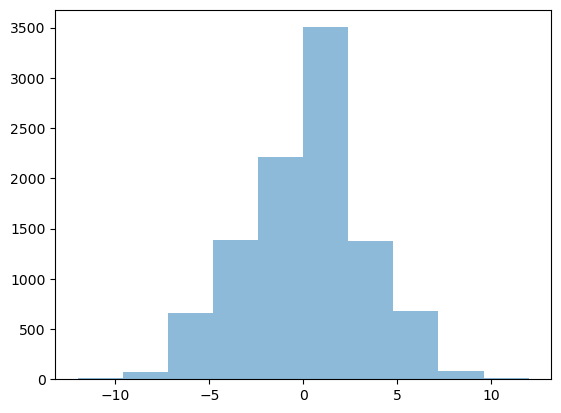

In [5]:
plt.hist(positions, bins=10, alpha=0.5)
plt.show()

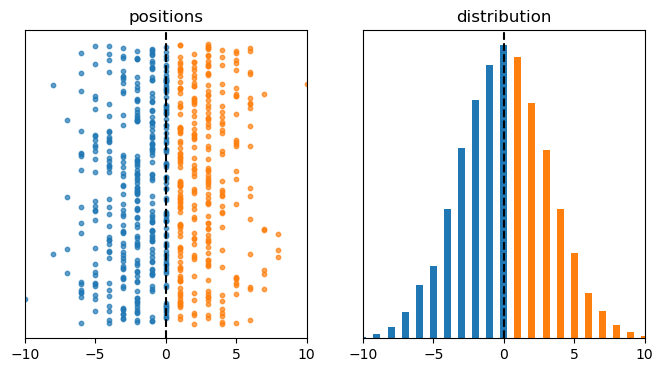

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))

# prep plot 1
plt.sca(axs[0])
plt.axvline(0, color='k', linestyle='--')
for ii, pos in enumerate(positions[::15]):
    color = 'C1' if pos > 0 else 'C0'
    plt.scatter(x=pos, y=ii, color=color, alpha=0.7, s=10)

plt.xlim([-10,10])
plt.yticks([])
plt.title("positions")

# Plot histogram
position_unique, position_counts = np.unique(positions, return_counts=True)
positive_idx = position_unique > 0
negative_idx = position_unique <= 0
plt.sca(axs[1])
plt.bar(position_unique[positive_idx], position_counts[positive_idx], width=.5, color='C1');
plt.bar(position_unique[negative_idx], position_counts[negative_idx], width=.5, color='C0');
plt.axvline(0, color='k', linestyle='--')
plt.xlim([-10, 10])
plt.yticks([])
plt.title("distribution");

plt.show()

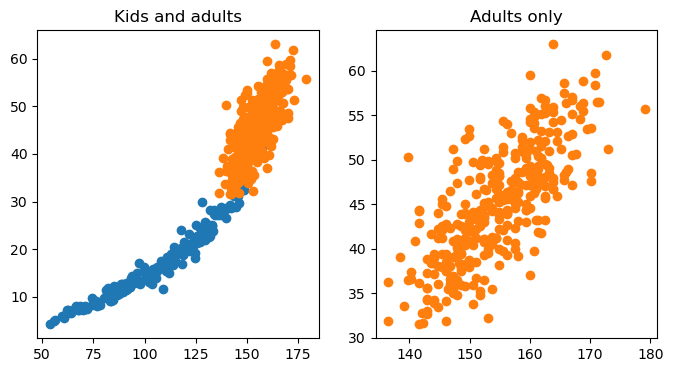

In [7]:
HOWELL = load_data("Howell1", delimiter=";", data_path="./data")
fig, axs = plt.subplots(1, 2, figsize=(8,4))

KIDS = HOWELL.filter(pl.col("age") <= 18)
ADULTS = HOWELL.filter(pl.col("age") > 18)

plt.sca(axs[0])
plt.scatter(x=KIDS["height"], y=KIDS["weight"], color="C0")
plt.scatter(x=ADULTS["height"], y=ADULTS["weight"], color="C1")
plt.title("Kids and adults")

plt.sca(axs[1])
plt.scatter(x=ADULTS["height"], y=ADULTS["weight"], color="C1")
plt.title("Adults only")

plt.show()


Now make a model for weight from height
That is what does height tell you about weight

In [8]:
def simulate_weight(H, beta, sigma):
    n_heights = len(H)
    # error
    U=stats.norm.rvs(0,sigma,size=n_heights)
    return beta * H + U

def likely_data(heights: pl.Series, beta: float, sigma: float) -> pl.Series:
    """
    Generative model that simulates weight given height
    
    """
    assert type(heights) is pl.Series
    assert sigma > 0
    return stats.norm.rvs(heights * beta, sigma)



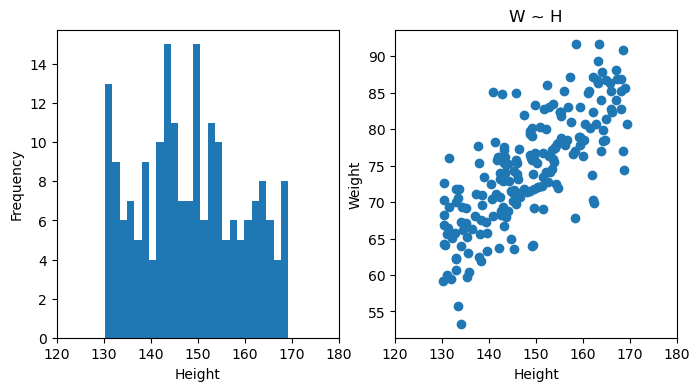

In [9]:
sim_heights = pl.Series(stats.uniform.rvs(size=200, loc=130,scale=40))
sim_weights = likely_data(sim_heights, beta=0.5, sigma=5)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
plt.sca(axs[0])
plt.hist(sim_heights, bins=25)
plt.xlim([120,180])
plt.xlabel("Height")
plt.ylabel("Frequency")

plt.sca(axs[1])
plt.scatter(x=sim_heights, y=sim_weights)
plt.xlim([120,180])
plt.xlabel("Height")
plt.ylabel("Weight")
plt.title("W ~ H")

plt.show()


Common parameterisation

$$
W_i \sim Normal(\mu_i, \sigma) \\
\mu_i = \alpha + \beta  H_i
$$

This says taht the mean weight is deterministically linked to the height via a line parameterised with an intercept $\alpha$ and a slope $\beta$, and that mean is in turn stochastically linked to the observed weight via the normal distribution. 

(-10.0, 60.0)

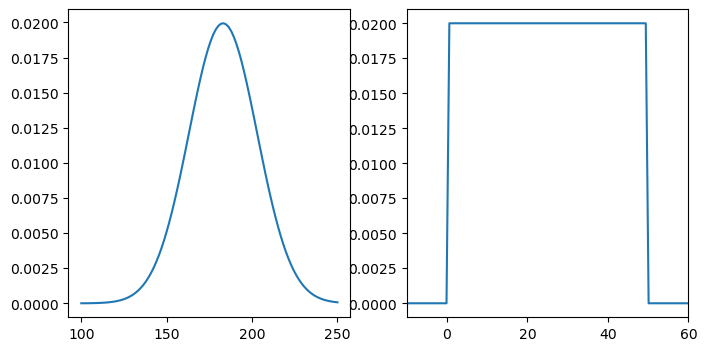

In [10]:
# We need a prior for the height, mu, and sigma
grid_mu = np.linspace(100,250,100)

pdf_mu = stats.norm.pdf(grid_mu, loc=183, scale=20)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
plt.sca(axs[0])
plt.plot(grid_mu, pdf_mu)
# but that's not all, the prior weight is a function of the prior on the mean and the standard deviation

# and then the prior for sigma
grid_sigma = np.linspace(-10,60,100)
plt.sca(axs[1])
pdf_sigma = stats.uniform.pdf(grid_sigma, loc=0, scale=50)
plt.plot(grid_sigma, pdf_sigma)
plt.xlim([-10,60])


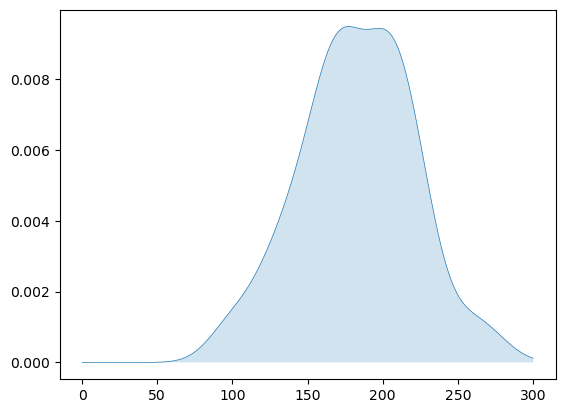

In [11]:
# prior predictive simulation
sample_mu = stats.norm.rvs(loc=183, scale=20, size=100)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=100)
# now simulate the prior heights by sampling from the distribution defined by these priors
prior_height = stats.norm.rvs(loc=sample_mu, scale=sample_sigma, size=100)

# plt.hist(prior_height, bins=100)

kde = stats.gaussian_kde(prior_height)
x = np.linspace(0, 300, 1000)
plt.plot(x, kde(x), lw=0.5) 
plt.fill_between(x, kde(x), alpha=0.2)
plt.show()

In [12]:
# Now predict the weight given these priors
# beta_0 = 

Let's do a grid search ... (R code 4.16 from rethinking)

In [63]:
np.random.seed(123)
N_DATA_POINTS = 64
RESOLUTION = 100
n_samples = 16


# Now set up as per the simulate_2_parameter_bayesian_learning method
DUMMY = False
if DUMMY:
    # dummy data to check
    SLOPE = 0.5
    INTERCEPT = -1
    x =stats.norm().rvs(size=N_DATA_POINTS)
    y = INTERCEPT + SLOPE * x + stats.norm().rvs(size=N_DATA_POINTS) 
    param_a_grid = np.linspace(-2, 2, RESOLUTION)
    param_b_grid = np.linspace(-2, 2, RESOLUTION)
    x_obs, y_obs = x[:n_samples], y[:n_samples]
    param_labels = ["x", "y"]
    data_range_x = (-3,3)
    data_range_y = (-3,3)

else: 
    HOWELL = load_data("Howell1", delimiter=";", data_path="./data")
    ADULTS = HOWELL.filter(pl.col("age") > 18)
    df = pl.from_dataframe(ADULTS)
    df = df.head(n_samples)
    x_obs, y_obs = df["height"], df["weight"]
    param_labels = ["height", "weight"]
    # intercept (represents the mean weight at the mean height)
    param_a_grid = np.linspace(25,125,RESOLUTION)
    # slope
    param_b_grid = np.linspace(-2,2,RESOLUTION)

    data_range_x = (x_obs.min(), x_obs.max())
    data_range_y = (y_obs.min(), y_obs.max())


def linear_model(x, intercept, slope):
    return intercept + slope * x

model_func = linear_model

def linear_regression_posterior(x_obs, y_obs, param_a_grid, param_b_grid, 
                                likelihood_prior_std=1.0,
                                intercept_prior = stats.norm(75,25),
                                slope_prior = stats.norm(0,1),
                                ):
    # check grids are simple arrays
    assert np.ndim(param_a_grid) == 1
    assert np.ndim(param_b_grid) == 1

    # log PDF of the prior for the intercept
    log_prior_intercept = intercept_prior.logpdf(param_a_grid)
    # log PDF of the prior for the slope
    log_prior_slope = slope_prior.logpdf(param_b_grid)

    # so the log likelihood is the sum
    log_likelihood = np.array(
        [
            stats.norm(
                intercept + slope * x_obs,
                likelihood_prior_std
            ).logpdf(y_obs) for intercept, slope in zip(param_a_grid, param_b_grid)
        ]
    ).sum(axis=1)

    # Posterior is the product of the likelihood and the prior
    log_posterior = log_likelihood + log_prior_intercept + log_prior_slope

    # Convert back to the natural scale
    return np.exp(log_posterior - log_posterior.max())

post_func = linear_regression_posterior

param_a_grid, param_b_grid = np.meshgrid(param_a_grid, param_b_grid)
param_a_grid = param_a_grid.ravel()
param_b_grid = param_b_grid.ravel()

posterior = post_func(x_obs, y_obs, param_a_grid, param_b_grid)




Text(0, 0.5, 'Weight')

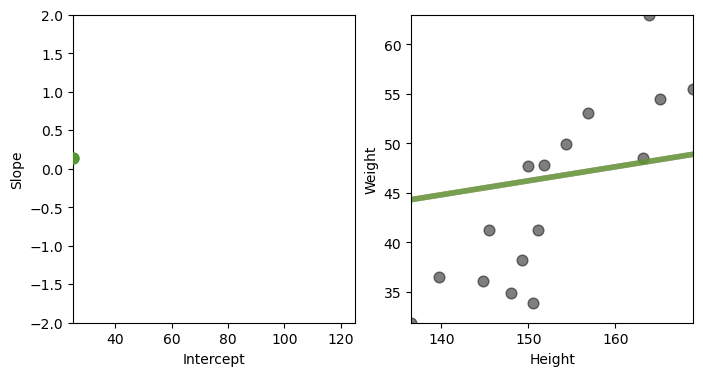

In [66]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
plt.sca(axs[0])
plt.contour(
    param_a_grid.reshape(RESOLUTION, RESOLUTION),
    param_b_grid.reshape(RESOLUTION, RESOLUTION),
    posterior.reshape(RESOLUTION, RESOLUTION),
    cmap="gray_r"
)

n_posterior_samples = 3
sample_idx = np.random.choice(
    np.arange(len(posterior)),
    p=posterior / posterior.sum(),
    size = n_posterior_samples,
)

param_a_list = []
param_b_list = []
for ii, idx in enumerate(sample_idx):
    param_a = param_a_grid[idx]
    param_b = param_b_grid[idx]
    param_a_list.append(param_a)
    param_b_list.append(param_b)

    # Add sampled parameters to posterior
    plt.scatter(param_a, param_b, s=60, c=f"C{ii}", alpha=0.75, zorder=20)


# add true params to plot
if DUMMY:
    plt.scatter(INTERCEPT, SLOPE, color="k", marker="x", s=60, 
            label="true parameters", zorder=10)

plt.xlabel("Intercept")
plt.ylabel("Slope")

# now plot lines sampled from the posterior
plt.sca(axs[1])
plt.scatter(x_obs, y_obs, c="k", s=60, alpha=0.5)

xs = np.linspace(data_range_x[0], data_range_x[1], 100)
for ii, (param_a, param_b) in enumerate(zip(param_a_list, param_b_list)):
    ys = model_func(xs, param_a, param_b)
    plt.plot(xs, ys, c=f"C{ii}", linewidth=4, alpha=0.5)

if DUMMY:
    groundtruth_ys = model_func(xs, INTERCEPT, SLOPE)
    plt.plot(xs, groundtruth_ys, c="k", linewidth=4, alpha=0.5, linestyle="--", label="true line")

plt.xlim(data_range_x)
plt.xlabel("Height")
plt.ylim(data_range_y)
plt.ylabel("Weight")

In [3]:
import numpy as np
np.random.multivariate_normal(mean=[0,1], cov=[[1,0],[0,1]], size=10)

array([[-0.28417873,  0.82026423],
       [-0.62094524,  0.75385443],
       [ 1.97314141,  1.22542326],
       [-1.45902135,  1.01627936],
       [ 1.22958613,  0.31522466],
       [ 1.77034366,  1.37830906],
       [ 0.52339848,  1.65658288],
       [-0.23267836,  1.46666767],
       [ 1.92582262,  1.58272649],
       [ 0.22784343,  0.89498326]])